In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import os
from tqdm import tqdm

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [2]:
EGFR_df = pd.read_csv(os.path.join("..", "2_adme_lead-likeness", "EGFR_lipinski.csv"))

In [3]:
EGFR_df.head()

,passed,Molecular mass,LogP,H-Donors,H-Acceptors,molecule_name,canonical_smiles,pIC50
0,True,383.814,4.45034,3,4,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,True,369.432,4.77200,1,6,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
2,True,283.287,2.31056,2,4,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
3,True,370.456,5.58790,1,5,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850
4,True,442.515,5.07900,3,3,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587


<h3>Zdefiniowanie parametrów i katalogu ze związkami PAINS</h3>

In [4]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

<h3>Szukanie związków PAINS w zbiorze danych i usunięcie ich ze zbioru danych</h3>

In [5]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(EGFR_df.iterrows(), total=EGFR_df.shape[0]):
    molecule = Chem.MolFromSmiles(row['canonical_smiles'])
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_name,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
EGFR_df_wo_pains = EGFR_df.loc[clean]  # keep molecules without PAINS

100%|██████████| 667/667 [00:02<00:00, 264.40it/s]


In [6]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(EGFR_df_wo_pains)}")

Number of compounds with PAINS: 71
Number of compounds without PAINS: 596


<h3>Wyświetlenie związków zaklasyfikowanych jako związki PAINS</h3>

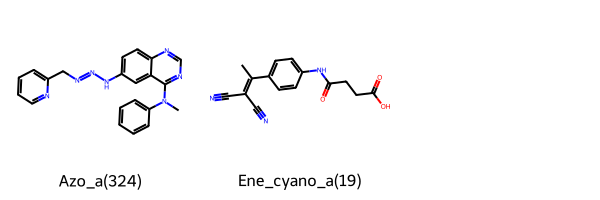

In [7]:
Chem.Draw.MolsToGridImage(
    list(matches.head(2).rdkit_molecule),
    legends=list(matches.head(2)["pains"]),
)

<h3>Wczytanie niechcianych związków z publikacji <i>Brenka et al.(Chem. Med. Chem. 2008, 3, 435-44)</i></h3>

In [8]:
substructures = pd.read_csv("unwanted_substructures.csv", sep=" ")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


<h3>Wyświetlenie przykładowych związków niepożądanych z powyższej publikacji</h3>

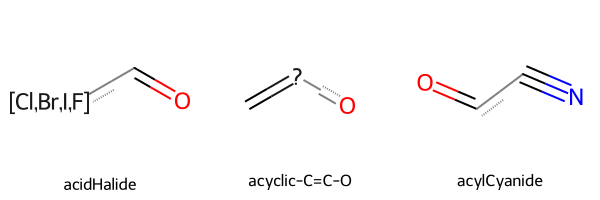

In [9]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

<h3>Znalezienie i usunięcie niechcianych struktur</h3>

In [10]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(EGFR_df_wo_pains.iterrows(), total=EGFR_df_wo_pains.shape[0]):
    molecule = Chem.MolFromSmiles(row["canonical_smiles"])
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_name,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
EGFR_clean = EGFR_df_wo_pains.loc[clean]

100%|██████████| 596/596 [00:03<00:00, 171.22it/s]


<h3>Zapisanie oczyszczonej matrycy do kolejnych zadań</h3>

In [ ]:
# EGFR_clean.to_csv("EGFR_clean.csv", index=False)

In [12]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(EGFR_clean)}")

Number of found unwanted substructure: 420
Number of compounds without unwanted substructure: 307


<h3>Wyświetlenie przykładowych niechcianych struktur z powyższej publikacji</h3>

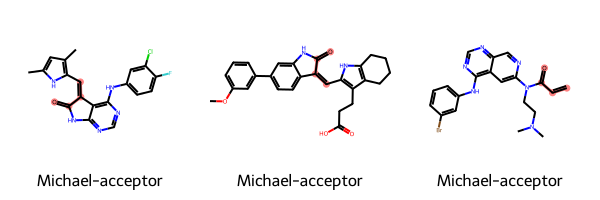

In [13]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

<h3>Wypisanie częstości występowania podstruktur</h3>

In [14]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor               153
Oxygen-nitrogen-single-bond     53
Aliphatic-long-chain            51
imine                           24
triple-bond                     24
nitro-group                     18
halogenated-ring                10
hydroxamic-acid                 10
Thiocarbonyl-group              10
alkyl-halide                     8
dtype: int64